ใน ep ที่แล้ว 

# 0. Install

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Install Library ที่จำเป็น

In [3]:
## Colab
! curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [4]:
! nvidia-smi

Mon Dec  9 05:05:39 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 1. Import

Import Library ที่จะใช้ ในที่นี้คือ fastai และ fastai.text 

In [0]:
from fastai import *
from fastai.text import *

In [0]:
# import fastai.utils.collect_env
# fastai.utils.collect_env.show_install()

# 2. Dataset

ในเคสนี้เราจะใช้ IMDB Movie Review เป็นรีวิวหนังจากเว็บ IMDB ที่มีข้อความ และ คะแนนว่าเป็นแง่บวก หรือแง่ลบ เหมือนใน ep ก่อน ๆ 

ในการพัฒนา เราจะใช้ Dataset ชุดเล็กก่อน จะได้เร็ว เมื่อเทสทุกอย่างเรียบร้อย แล้วจึงขยับไปใช้ Dataset ชุดเต็ม 

In [7]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

# 3. Preprocessing

## 3.1 Data Block API

เราจะใช้ [Data Block API](https://www.bualabs.com/archives/2693/data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/) กำหนด Data Pipeline ทีละขั้น Tokenization, Numericalization, Split, Labeling ก็จะทำให้ยืดหยุ่นมากขึ้น

In [8]:
data_lm = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

ดูตัวอย่างคำศัพท์ใน vocab Dictionary

In [9]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.',
 ',',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i']

ดูตัวอย่างข้อมูล text

In [10]:
data_lm.train_ds[0][0]

Text xxbos xxmaj un - xxunk - believable ! xxmaj meg xxmaj ryan does n't even look her usual xxunk lovable self in this , which normally makes me forgive her shallow xxunk acting xxunk . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj xxunk ... xxmaj xxunk ! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk !

ดูข้อมูลภายใน ในรูปแบบตัวเลข

In [12]:
data_lm.train_ds[0][0].data[:20]

array([   2,    5, 4619,   25,    0,   25,  867,   52,    5, 3776,    5, 1800,   95,   37,   85,  191,   64,  935,
          0, 2738])

# 2/2. Full Dataset

Download ชุดข้อมูลตัวเต็ม

In [13]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/README')]

In [14]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/pos')]

# 3/2. Preprocessing

Data Pipeline ด้วย Data Block API

In [0]:
# bs=48
# bs=24
bs=64

In [140]:
data_lm = (TextList.from_folder(path)
                    .filter_by_folder(include=['train', 'test', 'unsup'])
                    .split_by_rand_pct(0.1)
                    .label_for_lm()
                    .databunch(bs=bs, num_workers=1))

ในข้อมูล Training Set 90,000 Record มีคำศัพท์ 60,000 คำ (Default)

In [141]:
len(data_lm.vocab.itos), len(data_lm.train_ds)

(60000, 90000)

In [142]:
data_lm.show_batch()

idx,text
0,"utterly disappointed by the end . \n \n xxmaj the first 3 / 4 of the movie can best be described as uninspired and poorly directed ( sorry , xxmaj ade ! ) , but with some utterly brilliant moments . xxmaj unfortunately , these laugh - out - loud moments make you realize how less - than - brilliant the rest of the movie is . xxmaj the"
1,"orders through an open wall safe so his men do n't see who he is . xxmaj but the voice is unmistakable , you 'll know within 10 minutes of the film . \n \n xxmaj and another reviewer here is quite wrong , no squeals or groans from the audience would have occurred because xxmaj gabby xxmaj hayes was still playing a variety of roles and he 's"
2,"sebastien 's future features ) , you would just loose your time ... xxmaj there is something about french television that do n't smell right ... and this is xxmaj patrick xxmaj sebastien ! ! ! xxbos xxmaj some people say this show was good in it 's early years ! i disagree with all of 'em . xxmaj the show is just plain stupid and pathetic . xxmaj my"
3,"up with the most unoriginal lines in history , and 3 ) a neurotic but extremely pretty female programmer who tries to tell the coming president about this . xxmaj she 's soon the victim of the evil x - files master - lords of the computer company , who - instead of killing her - drug her to make her seem untrustworthy . xxmaj but , when she gets"
4,"person who was born and raised in xxmaj central xxmaj africa , i appreciated the authenticity of the film 's look and the honest depiction of daily life for the xxmaj zulu . xxmaj but this and the camera work are not enough to recommend the average viewer should see this film . xxmaj it takes an appreciation of true cinema and not just a love of movies to see"


เซฟไว้ก่อน 

In [0]:
data_lm.save('lm_databunch')

โหลด Language Model DataBunch ที่เซฟไว้ แล้วเช็คข้อมูล

In [144]:
data_lm = load_data(path, 'lm_databunch', bs=bs)
len(data_lm.vocab.itos), len(data_lm.train_ds)

(60000, 90000)

# 4. Language Model จาก WikiText-103

สร้าง Language Model Learner ขึ้นมา โดยใช้ data_lm จาก IMDB ด้านบน และ สถาปัตยกรรม AWD_LSTM [Model Architecture](https://www.bualabs.com/archives/2703/how-to-read-model-convolutional-neural-network-shape-activation-map-model-architecture-convnet-ep-7/) โดยที่ยังไม่ได้เริ่มต้นเทรน

AWD_LSTM ได้ถูก Pre-Train กับ WikiText-103 Dataset เรียบร้อยแล้ว

In [0]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
# learn_lm

In [146]:
learn_lm.model[0]

AWD_LSTM(
  (encoder): Embedding(60000, 400, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(60000, 400, padding_idx=1)
  )
  (rnns): ModuleList(
    (0): WeightDropout(
      (module): LSTM(400, 1152, batch_first=True)
    )
    (1): WeightDropout(
      (module): LSTM(1152, 1152, batch_first=True)
    )
    (2): WeightDropout(
      (module): LSTM(1152, 400, batch_first=True)
    )
  )
  (input_dp): RNNDropout()
  (hidden_dps): ModuleList(
    (0): RNNDropout()
    (1): RNNDropout()
    (2): RNNDropout()
  )
)

In [147]:
learn_lm.model[0].encoder

Embedding(60000, 400, padding_idx=1)

## 4.1 vocab Dictionary ของ WikiText-103 

โหลด Dictionary ของ WikiText-103 ขึ้นมา 

Language Model ต้องมาพร้อมกับ vocab Dictionary เสมอ ไม่เช่นนั้นเราจะไม่รู้ว่า คำศัพท์ไหนเป็นคำไหน เพราะในโมเดลจะเป็นตัวเลข Index / Embedding

In [148]:
Config().model_path().ls()

[PosixPath('/root/.fastai/models/wt103-fwd'),
 PosixPath('/root/.fastai/models/wt103-fwd.tgz')]

In [149]:
(Config().model_path()/'wt103-fwd').ls()

[PosixPath('/root/.fastai/models/wt103-fwd/itos_wt103.pkl'),
 PosixPath('/root/.fastai/models/wt103-fwd/lstm_fwd.pth')]

In [0]:
wiki_itos = pickle.load(open(Config().model_path()/'wt103-fwd/itos_wt103.pkl', 'rb'))

ดูจำนวนคำศัพท์ ตัวอย่างข้อมูล หัว / ท้าย

In [151]:
len(wiki_itos), wiki_itos[:20], wiki_itos[-20:]

(60000,
 ['xxunk',
  'xxpad',
  'xxbos',
  'xxeos',
  'xxfld',
  'xxmaj',
  'xxup',
  'xxrep',
  'xxwrep',
  'the',
  ',',
  '.',
  'of',
  'and',
  'in',
  'to',
  'a',
  '=',
  '"',
  'was'],
 ['repaying',
  'ak-47',
  'cultic',
  'jaume',
  'leonis',
  'subtracting',
  'sexed',
  'bursa',
  '-style',
  'lithographs',
  'wgbh',
  'subsystem',
  '831',
  'lifelines',
  'bergeron',
  'adaptions',
  'slurs',
  'acasta',
  'stuccoed',
  'spellbound'])

## 4.2 vocab Dictionary ของ IMDB

ดูตัวอย่างคำศัพท์ใน IMDB

In [0]:
vocab = data_lm.vocab

In [0]:
imdb_itos = vocab.itos

In [154]:
vocab.stoi['love']

134

In [155]:
imdb_itos[vocab.stoi['love']]

'love'

In [156]:
imdb_itos[vocab.stoi['Sukhumvit']]

'xxunk'

In [0]:
awd = learn_lm.model[0]

In [0]:
# from scipy.spatial.distance import cosine as dist

In [0]:
enc = learn_lm.model[0].encoder

Embedding 400 มิติของ คำศัพท์ 60,000 คำ

In [160]:
enc.weight.size()

torch.Size([60000, 400])

## 4.3 Difference in vocab between IMDB and Wikipedia

เปรียบเทียบ 2 vocab Dictionary พบว่า ขนาด vocab เท่ากัน

In [161]:
len(wiki_itos), len(imdb_itos)

(60000, 60000)

แต่ข้างใน ไม่เหมือนกัน เปรียบเทียบ 10 คำศัพท์สุดท้าย

In [162]:
wiki_itos[-10:], imdb_itos[-10:]

(['wgbh',
  'subsystem',
  '831',
  'lifelines',
  'bergeron',
  'adaptions',
  'slurs',
  'acasta',
  'stuccoed',
  'spellbound'],
 ['cabinets',
  'whoopin',
  'parco',
  'mashkov',
  'gouden',
  'desensitised',
  'boran',
  'manky',
  'commercializing',
  'misrepresent'])

In [0]:
wiki_words = set(wiki_itos)
imdb_words = set(imdb_itos)

คำศัพท์ที่อยู่ใน vocab ของ Wiki แต่ไม่อยู่ใน vocab ของ IMDB

In [164]:
wiki_not_imdb = wiki_words.difference(imdb_words)
len(wiki_not_imdb), [val for i, val in enumerate(itertools.islice(wiki_not_imdb, 20))]

(24263,
 ['antisense',
  'taman',
  'lapeer',
  'dunkerque',
  'tsr',
  'mạnh',
  'jackdaws',
  'cosmological',
  'uranian',
  'maint',
  'bellona',
  'plantings',
  'verification',
  'ceding',
  'phnom',
  'orators',
  'enver',
  'leed',
  'terhune',
  'dissociated'])

คำศัพท์ที่อยู่ใน vocab ของ IMDB แต่ไม่อยู่ใน vocab ของ Wiki

In [165]:
imdb_not_wiki = imdb_words.difference(wiki_words)
len(imdb_not_wiki), [val for i, val in enumerate(itertools.islice(imdb_not_wiki, 20))]

(24263,
 ['desny',
  'calson',
  'wonderous',
  'entertaingly',
  'pert',
  'detracts',
  "li'l",
  'arneric',
  'rafe',
  'henrickson',
  'anally',
  'kikuno',
  'exasperating',
  'welton',
  'sensationalize',
  'dopplegangers',
  'www.petitiononline.com',
  'yelli',
  'avakum',
  'vacillate'])

## 4.4 Out of vocab Initialization

คำว่า verification อยู่ใน vocab ของ WikiText-103 แต่ไม่อยู่ใน IMDB

In [166]:
w = "verification"
vocab.stoi[w], w in wiki_words, w in imdb_words

(0, True, False)

คำเหล่านี้ อยู่ใน vocab ของ IMDB แต่ไม่อยู่ใน WikiText-103 เราจะ Initialize Embedding ของคำเหล่านี้ แบบ Random

In [167]:
w = "senselessness"
vocab.stoi[w], w in wiki_words, w in imdb_words

(35310, False, True)

In [168]:
w = "unthinking"
vocab.stoi[w], w in wiki_words, w in imdb_words

(26364, False, True)

In [169]:
w = "forklift"
vocab.stoi[w], w in wiki_words, w in imdb_words

(45314, False, True)

Initialize ด้วยค่า Random เล็ก ๆ ใกล้เคียงกัน

In [170]:
np.allclose(enc.weight[vocab.stoi['senselessness'], :], 
            enc.weight[vocab.stoi['unthinking'], :])

True

แต่ถ้าเทียบกับ Embedding ที่เทรนเรียบร้อยแล้ว ก็จะต่างกันมาก

In [171]:
np.allclose(enc.weight[vocab.stoi['senselessness'], :], 
            enc.weight[vocab.stoi['capital'], :])

False

3 คำแรกมีใน IMDB แต่คำสุดท้ายไม่มี

In [172]:
vocab.stoi['senselessness'], vocab.stoi['unthinking'], vocab.stoi['capital'], vocab.stoi['cpu']

(35310, 26364, 5670, 0)

ดู Embedding ของคำที่มีใน IMDB แต่ไม่มีใน Wiki จะเห็นว่าเท่ากันมีค่าเท่ากัน

In [173]:
len(enc.weight[vocab.stoi['senselessness'], :]), enc.weight[vocab.stoi['senselessness'], :][:50]

(400,
 tensor([ 0.0253,  0.0026,  0.0423, -0.0274, -0.0110, -0.0100, -0.0628,  0.1794,
         -0.1275, -0.2096, -0.0124, -0.0056, -0.0505, -0.0501, -0.0428,  0.1726,
         -0.0650, -0.0571, -0.1103,  0.0186,  0.0053, -0.0059,  0.0299,  0.0192,
         -0.0240,  0.1432, -0.1064, -0.0097,  0.0100, -0.0399,  0.0282,  0.0319,
          0.1297,  0.0687, -0.0047,  0.0168,  0.0201,  0.1346, -0.0336, -0.0449,
          0.0265, -0.0756, -0.0225,  0.0196,  0.0221,  0.0214,  0.0077, -0.1311,
         -0.1357, -0.0128], device='cuda:0', grad_fn=<SliceBackward>))

In [174]:
len(enc.weight[vocab.stoi['unthinking'], :]), enc.weight[vocab.stoi['unthinking'], :][:50]

(400,
 tensor([ 0.0253,  0.0026,  0.0423, -0.0274, -0.0110, -0.0100, -0.0628,  0.1794,
         -0.1275, -0.2096, -0.0124, -0.0056, -0.0505, -0.0501, -0.0428,  0.1726,
         -0.0650, -0.0571, -0.1103,  0.0186,  0.0053, -0.0059,  0.0299,  0.0192,
         -0.0240,  0.1432, -0.1064, -0.0097,  0.0100, -0.0399,  0.0282,  0.0319,
          0.1297,  0.0687, -0.0047,  0.0168,  0.0201,  0.1346, -0.0336, -0.0449,
          0.0265, -0.0756, -0.0225,  0.0196,  0.0221,  0.0214,  0.0077, -0.1311,
         -0.1357, -0.0128], device='cuda:0', grad_fn=<SliceBackward>))

ต่างกับค่าที่มีใน Wiki

In [175]:
len(enc.weight[vocab.stoi['capital'], :]), enc.weight[vocab.stoi['capital'], :][:50]

(400,
 tensor([-0.2566,  0.1062,  0.3081,  0.2742,  0.1667, -0.1626, -0.5122, -0.1261,
          0.4548, -0.4177, -0.1565,  0.0752,  0.2253,  0.2031, -0.3125,  0.0310,
          0.5112, -0.3691, -0.2947, -0.0168, -0.1147,  0.3074, -0.1654, -0.2202,
          0.0538, -0.4041,  0.1666, -0.0109, -0.2803,  0.3044, -0.2279,  0.1786,
         -0.2502, -0.2334,  0.4438,  0.2404,  0.1746,  0.1509,  0.0351,  0.2844,
         -0.0244, -0.2031,  0.1228, -0.2357, -0.2065,  0.5811,  0.1338,  0.4087,
         -0.5034, -0.0150], device='cuda:0', grad_fn=<SliceBackward>))

## 4.5 Fake Movie Reviews from WikiText Language Model

ชอบหนังเรื่องนี้เพราะว่า

In [0]:
TEXT = "I loved this film because"
N_WORDS = 60
N_SENTENCES = 3

In [177]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I loved this film because it 's a real wreck . " It has been described as an intergalactic disaster and is the only example of " the limited - documentary film of its kind . " In the United States , the film was parodied by Scottish filmmaker John Paul Hopkins in a 2007 feature film
I loved this film because of its love , its vision , and its message of love . The concept of , like , the world 's Insignificant King was inspired by the life and death of British people from the Mediterranean . It was inspired by the United Kingdom , where the Canadian Army
I loved this film because of its black and white background . This , and the image of the female lead , were used by Edward Newman for his October 1997 film The King of Hungary . It was the childhood title of the film , which David Lynch read for the British film


ไม่ชอบหนังเรื่องนี้เพราะว่า

In [0]:
TEXT = "I hated this movie because"
N_WORDS = 60
N_SENTENCES = 3

In [179]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie because it , along with many other films and television shows , was an inspiration for other films . However , the film was initially not based on the Hell in a Cell , but instead went out of use , in order to avoid bloodshed . The film was released on the Blu - ray
I hated this movie because of its elements , but it did feel like a movie . The film was well received by critics and was described as an " interesting and convincing film " . In February 2000 , the American Film Institute listed it as one of the " Ten Most Interesting Movies
I hated this movie because it was a fan of the magazine , and it was in fact the first picture of the French Revolution in the world . The film was released to the public on September 7 , 1999 . It was released theatrically in Mexico on October 23 , 1999 , in Spain ,


หนังเรื่องนี้ ... จริง ๆ

In [0]:
TEXT = "This movie is really"
N_WORDS = 60
N_SENTENCES = 3

In [181]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

This movie is really a movie , for it is one of the most popular films ever released , and it has been the subject of several biographical films , including the films The World of God and Hancock ( 2008 ) . 
 
  = = = Films = = = 
 
  In the early 1980s ,
This movie is really a miniseries , typically titled The Catalyst . Though the black - and - white version , by King Mark Hill , shows King Arthur and Queen Victoria , it is not based on the British or Japanese accounts . The Emperor also dislikes the
This movie is really based on a church in Europe , though it was made in England , France and England . In addition , the French Ambassador Louis Saint - Jacques was surprised at the US response , saying that he could not remember the physical appearance of the French at


ลด temperature ลง ทำให้ข้อความ Random น้อยลง

In [0]:
TEXT = "This movie is really"
N_WORDS = 60
N_SENTENCES = 3

In [183]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.1) for _ in range(N_SENTENCES)))

This movie is really a British film , and it is a film that is not a direct sequel to the British film . The film is a prequel to the film , and is a prequel to the film . The film was released on DVD in November 2009 . 
 
  = = Reception = =
This movie is really a British film , and it is the first film to be filmed in London . The film was shot in London , England , and London , and was shot in London . The film was shot in London , England , and London . The film
This movie is really a Hollywood film , and it is a film that is not a direct sequel to the Hollywood film . The film is a sequel to the original Star Wars film , and the film is not a sequel to the original Star Wars film . The film was released on


# 5. Train Model

## 5.1 Train Last Layer

เทรน Layer สุดท้าย

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 5.75E-03


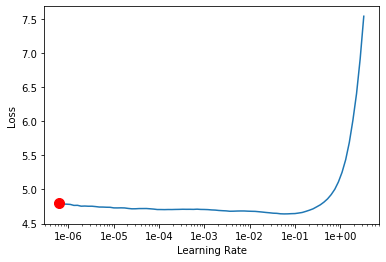

In [187]:
learn_lm.lr_find()
learn_lm.recorder.plot(suggestion=True)

In [0]:
lr = 1e-2

In [0]:
learn_lm.to_fp16()

In [0]:
learn_lm.fit_one_cycle(1, lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time


In [0]:
learn_lm.save("26g-01")

In [0]:
learn_lm.load("26g-01");

## 5.2 Unfreeze and Train whole model

In [0]:
learn_lm.unfreeze()

In [0]:
learn_lm.lr_find()
learn_lm.record.plot(suggestion=True)

In [0]:
lr = slice(1e-6, 3e-4)

In [0]:
learn_lm.fit_one_cycle(10, max_lr=lr, moms=(0.8, 0.7))

In [0]:
learn_lm.save("26g-02")

In [0]:
learn_lm.save_encoder("26g-02-enc")

In [0]:
learn_lm.load("26g-02");

## 5.3 Check Embedding Again

In [0]:
np.allclose(enc.weight[vocab.stoi['senselessness'], :], 
            enc.weight[vocab.stoi['unthinking'], :])

True

แต่ถ้าเทียบกับ Embedding ที่เทรนเรียบร้อยแล้ว ก็จะต่างกันมาก

In [0]:
np.allclose(enc.weight[vocab.stoi['senselessness'], :], 
            enc.weight[vocab.stoi['capital'], :])

False

3 คำแรกมีใน IMDB แต่คำสุดท้ายไม่มี

In [0]:
vocab.stoi['senselessness'], vocab.stoi['unthinking'], vocab.stoi['capital'], vocab.stoi['cpu']

(35310, 26364, 5670, 0)

ดู Embedding ของคำที่มีใน IMDB แต่ไม่มีใน Wiki จะเห็นว่าเท่ากันมีค่าเท่ากัน

In [0]:
len(enc.weight[vocab.stoi['senselessness'], :]), enc.weight[vocab.stoi['senselessness'], :][:50]

(400,
 tensor([ 0.0253,  0.0026,  0.0423, -0.0274, -0.0110, -0.0100, -0.0628,  0.1794,
         -0.1275, -0.2096, -0.0124, -0.0056, -0.0505, -0.0501, -0.0428,  0.1726,
         -0.0650, -0.0571, -0.1103,  0.0186,  0.0053, -0.0059,  0.0299,  0.0192,
         -0.0240,  0.1432, -0.1064, -0.0097,  0.0100, -0.0399,  0.0282,  0.0319,
          0.1297,  0.0687, -0.0047,  0.0168,  0.0201,  0.1346, -0.0336, -0.0449,
          0.0265, -0.0756, -0.0225,  0.0196,  0.0221,  0.0214,  0.0077, -0.1311,
         -0.1357, -0.0128], device='cuda:0', grad_fn=<SliceBackward>))

In [0]:
len(enc.weight[vocab.stoi['unthinking'], :]), enc.weight[vocab.stoi['unthinking'], :][:50]

(400,
 tensor([ 0.0253,  0.0026,  0.0423, -0.0274, -0.0110, -0.0100, -0.0628,  0.1794,
         -0.1275, -0.2096, -0.0124, -0.0056, -0.0505, -0.0501, -0.0428,  0.1726,
         -0.0650, -0.0571, -0.1103,  0.0186,  0.0053, -0.0059,  0.0299,  0.0192,
         -0.0240,  0.1432, -0.1064, -0.0097,  0.0100, -0.0399,  0.0282,  0.0319,
          0.1297,  0.0687, -0.0047,  0.0168,  0.0201,  0.1346, -0.0336, -0.0449,
          0.0265, -0.0756, -0.0225,  0.0196,  0.0221,  0.0214,  0.0077, -0.1311,
         -0.1357, -0.0128], device='cuda:0', grad_fn=<SliceBackward>))

ต่างกับค่าที่มีใน Wiki

In [0]:
len(enc.weight[vocab.stoi['capital'], :]), enc.weight[vocab.stoi['capital'], :][:50]

(400,
 tensor([-0.2566,  0.1062,  0.3081,  0.2742,  0.1667, -0.1626, -0.5122, -0.1261,
          0.4548, -0.4177, -0.1565,  0.0752,  0.2253,  0.2031, -0.3125,  0.0310,
          0.5112, -0.3691, -0.2947, -0.0168, -0.1147,  0.3074, -0.1654, -0.2202,
          0.0538, -0.4041,  0.1666, -0.0109, -0.2803,  0.3044, -0.2279,  0.1786,
         -0.2502, -0.2334,  0.4438,  0.2404,  0.1746,  0.1509,  0.0351,  0.2844,
         -0.0244, -0.2031,  0.1228, -0.2357, -0.2065,  0.5811,  0.1338,  0.4087,
         -0.5034, -0.0150], device='cuda:0', grad_fn=<SliceBackward>))

# สรุป

* เราได้เรียนรู้ว่า 

# Credit

* https://www.youtube.com/watch?v=dt7sArnLo1g&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=6&t=0s
* https://www.bualabs.com/archives/2693/data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/
* https://www.bualabs.com/archives/926/sentiment-analysis-imdb-movie-review-ulmfit-sentiment-analysis-ep-1/
* https://www.bualabs.com/archives/3000/sentiment-classification-imdb-movie-reviews-with-naive-bayes-logistic-regression-nlp-ep-5/
* https://docs.fast.ai/data_block.html
* https://docs.fast.ai/text.data.html
* https://forums.fast.ai/t/language-model-zoo-gorilla/14623
* https://www.imdb.com/interfaces/
* https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/
* https://arxiv.org/abs/1801.06146
* 